In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import os
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse



!pip install fuzzywuzzy
!pip install rapidfuzz
from rapidfuzz import process
from fuzzywuzzy import fuzz, process



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Loading the datasets
movies = pd.read_csv('/content/drive/MyDrive/dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/dataset/ratings.csv')

In [3]:
# Creating a new_movieId for every movie to reduce the range of existing movieId
movies["new_movieId"] = range(1, movies["movieId"].nunique() + 1)

# Updating the movieId in movies and ratings with the new_movieId
ratings = ratings.merge(movies[["movieId", "new_movieId"]], how="left", on="movieId")
ratings["movieId"] = ratings["new_movieId"]
movies["movieId"] = movies["new_movieId"]

# Dropping the new_movieId column
ratings.drop(["new_movieId"], axis=1, inplace=True)
movies.drop(["new_movieId"], axis=1, inplace=True)

<ipython-input-4-d721268c6611>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette="viridis")
<ipython-input-4-d721268c6611>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{num / 10**6:.1f}M" for num in ax.get_yticks()])


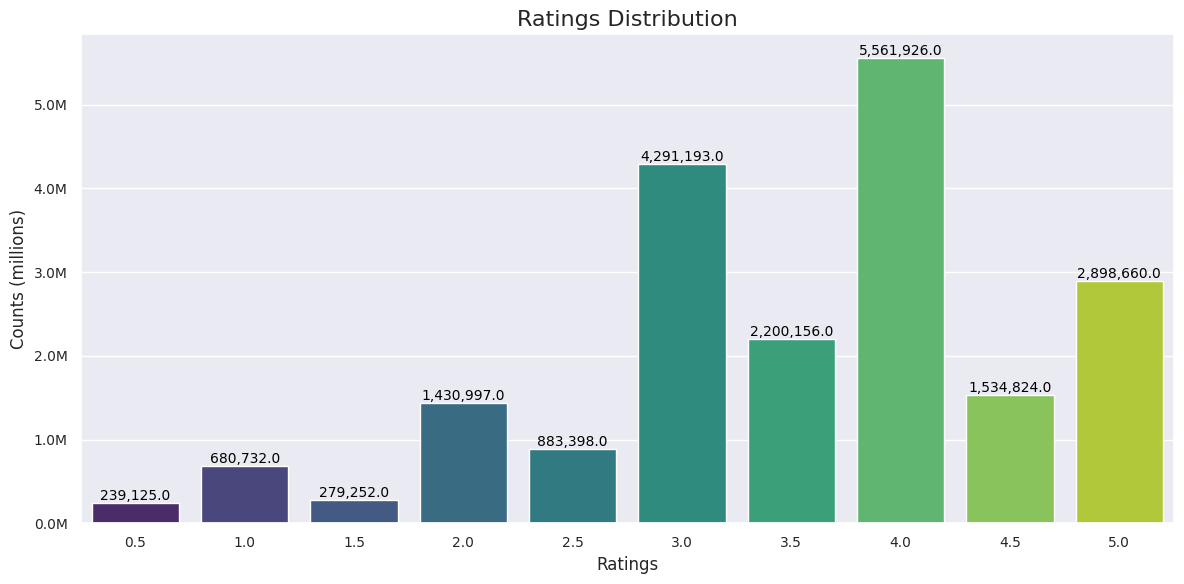

In [4]:

def visualize_rating_distribution(data, column="rating", title="Distribution of Ratings"):
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 6))

    # Plot the countplot
    ax = sns.countplot(x=column, data=data, palette="viridis")

    # Annotate bars with counts
    for bar in ax.patches:
        ax.annotate(f'{bar.get_height():,}',
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

    # Format y-axis labels directly inline
    ax.set_yticklabels([f"{num / 10**6:.1f}M" for num in ax.get_yticks()])

    # labels and title
    plt.title(title, fontsize=16)
    plt.xlabel("Ratings", fontsize=12)
    plt.ylabel("Counts (millions)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # plot
    plt.tight_layout()
    plt.show()

visualize_rating_distribution(ratings, column="rating", title="Ratings Distribution")

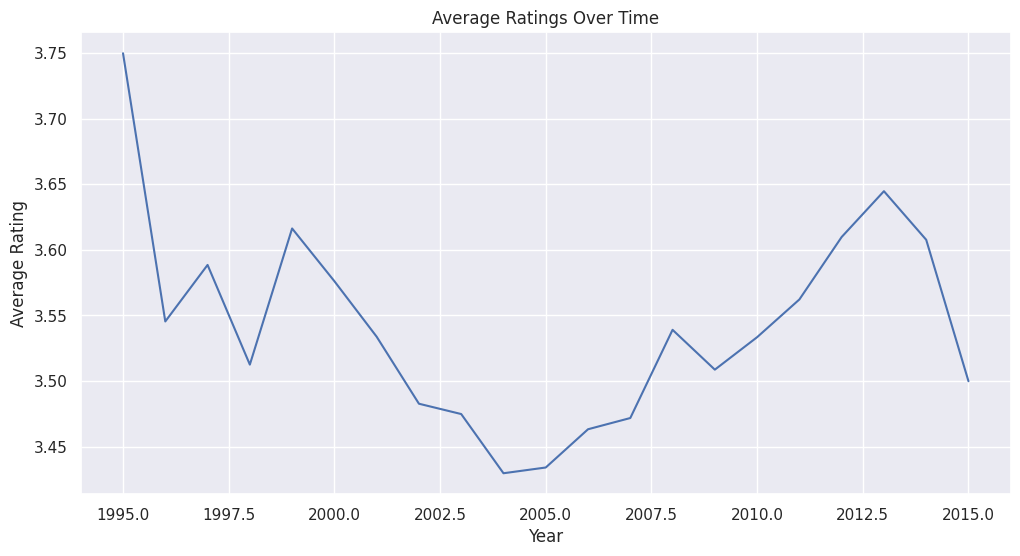

In [5]:
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
yearly_ratings = ratings.groupby('year')['rating'].mean()
yearly_ratings.plot(figsize=(12, 6), title="Average Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()

In [6]:

user_item_matrix = sparse.csr_matrix((ratings["rating"], (ratings["userId"], ratings["movieId"])))

# Computing the movie-movie similarity matrix
similarity_matrix = cosine_similarity(user_item_matrix.T, dense_output=False)


movie_df = movies[['movieId', 'title', 'genres']].drop_duplicates()
movie_df = movie_df.reset_index(drop=True)

In [7]:
def Movie_MovieSimilarity(movie_name, num_of_sim):
    # Finding the closest match to the movie name
    Similarmov = process.extract(movie_name, movie_df["title"], scorer=fuzz.partial_ratio)
    if not Similarmov:
        return "No Similar Movie"

    movie_id = movie_df.iloc[Similarmov[0][2]]["movieId"]

    #similarity scores for the movie
    similarity_scores = similarity_matrix[movie_id].toarray().ravel()
    similarity_scores[movie_id] = -1  # Exclude the movie itself

    similar_movie_ids = np.argsort(-similarity_scores)[:num_of_sim]

    # dataframe of similar movies
    similar_movie_df = movie_df[movie_df["movieId"].isin(similar_movie_ids)].copy()
    similar_movie_df["similarity"] = similar_movie_df["movieId"].apply(lambda x: similarity_scores[x])
    similar_movie_df = similar_movie_df.sort_values(by="similarity", ascending=False)
    similar_movie_df.reset_index(drop=True, inplace=True)

    return similar_movie_df

In [8]:
movie_name = "Godfather"
num_of_sim = 10
recommended_movies = Movie_MovieSimilarity(movie_name, num_of_sim)
recommended_movies

,movieId,title,genres,similarity
0,1196,"Godfather: Part II, The (1974)",Crime|Drama,0.763149
1,1188,Goodfellas (1990),Crime|Drama,0.580992
2,1174,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0.561982
3,258,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.560467
4,1170,One Flew Over the Cuckoo's Nest (1975),Drama,0.558973
5,1172,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.542894
6,1183,Apocalypse Now (1979),Action|Drama|War,0.527719
7,603,Fargo (1996),Comedy|Crime|Drama|Thriller,0.527213
8,2487,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.520429
9,1068,Reservoir Dogs (1992),Crime|Mystery|Thriller,0.518102


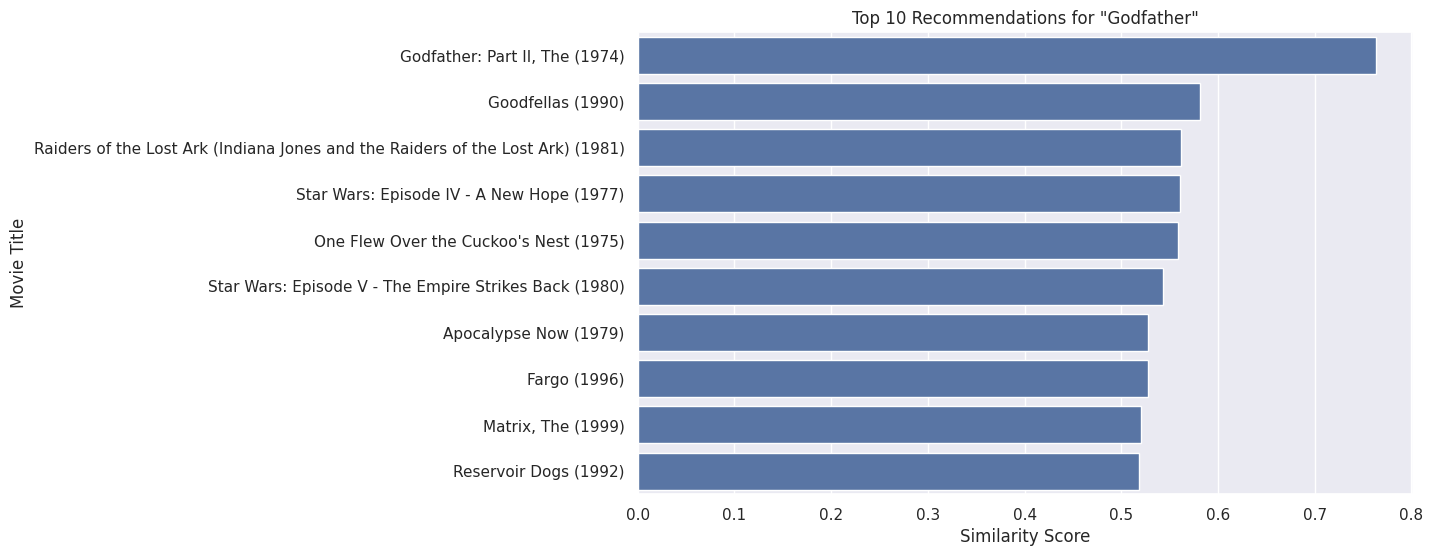

In [9]:
def movie_movie_plot(movie_name, num_recommendations):
    recommended_movies = Movie_MovieSimilarity(movie_name, num_recommendations)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='similarity', y='title', data=recommended_movies)
    plt.title(f'Top {num_recommendations} Recommendations for "{movie_name}"')
    plt.xlabel('Similarity Score')
    plt.ylabel('Movie Title')
    plt.show()


movie_movie_plot('Godfather', 10)